In [1]:
import os
import shutil
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

import tensorflow.keras.layers as tkl
import tensorflow.keras as tk
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

In [3]:
# Uncomment if you know what you're doing
shutil.rmtree('logs', ignore_errors=True)

from datetime import datetime
logdir = "./logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tk.callbacks.TensorBoard(log_dir=logdir)
os.makedirs(logdir, exist_ok=True)
print("Logging to %s" % logdir)

Logging to ./logs/scalars/20191026-104059


Execute ```tensorboard --logdir ./logs``` on a terminal in this directory to watch the 
training converge as you continue with this notebook.

---

# The Supervised Learning Problem

Trading is a process that influences the environment. Transactions create fees, larger transactions will even influence prices. That's why we'll eventually be looking at this problem as a *Reinforcement Learning* (RL) problem. But for now, we'll concentrate on the questions whether a neural network can learn when to buy and when to sell, when it is trained by some heuristically derived labels. In RL, people would talk about expert training. The heuristic is the expert.

So: We set out to train an artificial neural network when to buy and when to sell. Let's define that challenge in easy mathematical terms, such that we can start implementing it. We are looking for a function that take as input some well-defined data from the market and our current portfolio and outputs a rebalancing recommendation.

### Prerequisites
In our experiment, we call 256 business days a year. GPUs are most efficient to chew on chunks with sizes of powers of two, that's why. Since we decided to study a synthetic case, that is not a limitation. Funny enough - it's quite close to reality, too.

### Input: Market Data
The market data input is described in [Understanding_the_Market.ipynb](Understanding_the_Market.ipynb). 

### Input: Expert Labels
We'll create some heuristic function that would always suggest to put the money in the single stock that has performed best during the last $n_d$ days, with $n_d$ being a duration between 2 and 128 days

### Output
The output of our neural network function is a new set of weights for the portfolio and the cash position. Once we're getting to *Reincorcement Learning*, we're going to call this function a *policy*, as it *suggests* the next action of rebalancing the portfolio. 

### Objective
What we're tryng to achieve is that the neural network will eventually copy the heuristic behaviour and only invest in the top-mover. Once that is working, we'll do the *real stuff*: Deep Reinforcement Learning. But for now, it's supervised learning.


## Using pre-produced data
Since the creation of market data takes such a long time, we'll be using pre-produced history data available in files. These files contain data of several different simulation runs. You can observe that the different runs produce very different data, although the *investors* are trading in exactly the same sentiment history. That's because the investors are created with random preferences for momentum and value and also their perception of the expected perceived value is modelled with some noise in it.

In [4]:
data = []
with open('charts.pkl', 'rb') as file:
    r=0
    while True:
        try: 
            data.append(pickle.load(file))
            r+=1
        except EOFError:
            print("Read %s samples." % r)
            break;


Read 2 samples.


Charts from two different simulation runs for the same sentiment history

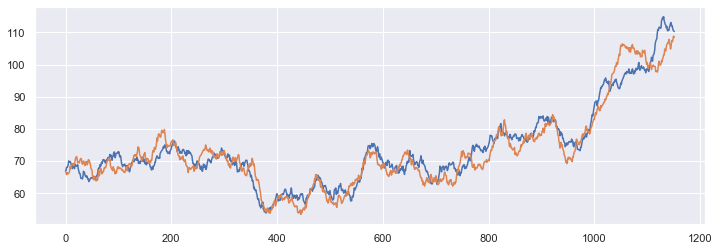

In [5]:
tickers = list(data[0].keys())
ticker = tickers[0]
plt.plot(data[0][ticker]['price']);
plt.plot(data[1][ticker]['price']);

## A market-like data source

In [6]:
from markets.stocks_model import MarketFromData

In [7]:
all_charts = np.array([data[0][ticker]['price'] for ticker in tickers])
market = MarketFromData(all_charts, 1024, 128, fee=2.5e-3)

This *market* is basically a data source, not a dynamic object the exposes behavior. We can ask it about the most recent price history of 8 closing prices of each traded stock as observed on the 200th trading day like this:

In [8]:
market.log_return_history(nh=8, t=200)

array([[ 0.01158543,  0.01018468, -0.00675895,  0.03029789,  0.        ,
        -0.00315781,  0.00540038, -0.00892717,  0.01403414,  0.03342717],
       [ 0.01713031,  0.00757101, -0.00680495,  0.        ,  0.01907272,
        -0.01273193, -0.01628944, -0.00599603,  0.0110872 , -0.00470744],
       [-0.01138754, -0.00504097, -0.01029504,  0.01112916, -0.00949089,
         0.01903762, -0.00824532,  0.00898062,  0.00823547,  0.00470744],
       [-0.02317164,  0.00504097,  0.        ,  0.        ,  0.01420277,
        -0.00314787, -0.00831387, -0.00597811,  0.0081682 ,  0.01399081],
       [-0.02372133, -0.01519979,  0.00687512,  0.00368236, -0.00471188,
         0.00628587,  0.        , -0.00601406,  0.00810202,  0.02289163],
       [ 0.        , -0.00768742,  0.01022486,  0.00366885,  0.0506484 ,
         0.01862396, -0.00558123, -0.00605045,  0.01600973, -0.0045366 ],
       [ 0.00896157,  0.        ,  0.01347253,  0.00729757,  0.        ,
         0.0091835 ,  0.01113148,  0.        

In [9]:
# One million in cash and 100'000 worth of every available stock
portfolio= [1e6] + 10 * [1e5]
print(portfolio)

[1000000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]


### OpenAI's *environment*
[OpenAI](https://openai.com/) has invented the concept of an *environment*, which basically is something - an object, or a concept - that maintains a state and transitions from one particular state to the next according to given *actions*. The methods ```state()``` and ```env.step(action)``` implement those concepts in our ```MarketEnvironment``` .

In [30]:
from drl.trading_model import MarketEnvironment

In [31]:
env = MarketEnvironment(
    market=market, 
    n_hist=128, 
    t_init=0, 
    portfolio=portfolio,     
    return_scale = 100,  # multiply daily log returns by 100 for computational efficiency
    weight_scale = 1.0
)

### The environment provides input data
#### Market price history
In the tradition of openai's environment, we get our input data by querying the state of the environment. First we see the price history already shaped such that it can readily be fed into a convolutional neural network: 1 channel (colour images would have a three here), input as 10 stocks with 128 points of history data, and 1 for the number of records in a batch, since we have a single observation.

In [32]:
history, weights = env.state()
history.shape

(1, 128, 10, 1)

And the other part is the current portfolio including the cash position. In this supervised setup we'll be using only the market history. We'll be taking 1024 different history records - one for every day within the 4-year period.

#### Portfolio weights

In [13]:
weights

array([[0.5 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],
      dtype=float32)

Later, we will interact with this environment by calling the ```step(...)``` method that takes the new portfolio weights as input. Note that this environment does not actually execute the trade on it's underlying market instance, since (remember?) that instance is a read-only market. The environment does re-balance the portfolio though and it also subtracts the fee that the market demands.

#### Input data in Batches
In this supervised learning setup, we're only interested in the market history. We want to see that a convolutional network is able to recognize a simple pattern - a general uptrend. To be more precise, the convolutional neural network should be able to point out the stock with the maximum return within the past 128 days.

In [14]:
hist = env.state()[0]/100.
h_list = [hist]
for _ in range(1023):
    observation = env.step(weights[0])
    hist = observation.s1[0]
    hist = np.expand_dims(hist, axis=-1)
    hist = np.expand_dims(hist, axis=0)
    h_list.append(hist)
batch = np.vstack(h_list).astype(np.float32)
batch.shape    

(1024, 128, 10, 1)

It's always beneficial to look at the data and understand the structure. Here, we see the first three *snapshots* (block-wise), five consecutive prices (top to bottom in each block), 4 stocks (left to right). You should be able to recognize the sliding time window here, as the numbers appear to move up.

In [15]:
batch[0:3, 0:5, :4, 0] 

array([[[ 0.        ,  0.00562194,  0.00378208,  0.02555519],
        [ 0.01480346,  0.00837409,  0.00752152,  0.00628804],
        [ 0.        ,  0.00554402, -0.0113036 ,  0.00624875],
        [ 0.00293458, -0.00554402, -0.00379644, -0.00938783],
        [ 0.00875241, -0.01118111,  0.00379644, -0.00314896]],

       [[ 0.01480346,  0.00837409,  0.00752152,  0.00628804],
        [ 0.        ,  0.00554402, -0.0113036 ,  0.00624875],
        [ 0.00293458, -0.00554402, -0.00379644, -0.00938783],
        [ 0.00875241, -0.01118111,  0.00379644, -0.00314896],
        [ 0.0172783 ,  0.01118111,  0.0113036 ,  0.        ]],

       [[ 0.        ,  0.00554402, -0.0113036 ,  0.00624875],
        [ 0.00293458, -0.00554402, -0.00379644, -0.00938783],
        [ 0.00875241, -0.01118111,  0.00379644, -0.00314896],
        [ 0.0172783 ,  0.01118111,  0.0113036 ,  0.        ],
        [-0.00572633, -0.00278358,  0.02223096, -0.00950683]]],
      dtype=float32)

#### Heuristics

In [16]:
winners = []
losers = []
for sample in batch:
    deltas = []
    for ticker in range(10):
        cumsum = sample[:, ticker, 0].cumsum()
        deltas.append(cumsum[-1] - cumsum[0])
    winner = np.where(deltas == max(deltas))[0][0]
    winners.append(winner)
    loser = np.where(deltas == min(deltas))[0][0]
    losers.append(loser)

7


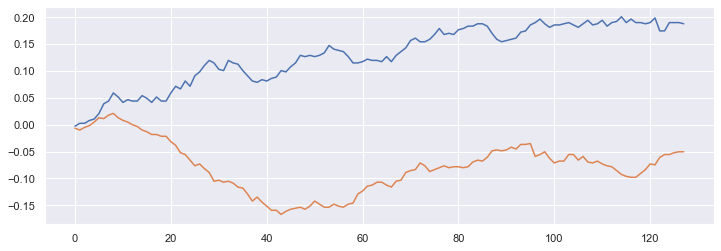

In [17]:
n = 800
print(winners[n])
plt.plot(batch[n, :, winners[n], 0].cumsum());
plt.plot(batch[n, :, losers[n], 0].cumsum());

The ```heuristic_winner``` function returns a *one_hot*-encoded representation of the best performing stock for each of the 1024 samples of 128 prices.

In [18]:
def heuristic_winner(batch):
    n_stocks = batch.shape[2]
    winners = []
    for sample in batch:
        deltas = []
        for ticker in range(n_stocks):
            cumsum = sample[:, ticker, 0].cumsum()
            deltas.append(cumsum[-1] - cumsum[0])
        winner = np.where(deltas == max(deltas))[0][0]
        one_hot = np.diag(np.ones(n_stocks+1))[winner]
        winners.append(one_hot)
    return np.array(winners).astype(np.float32)

In [19]:
winners = heuristic_winner(batch)

In [20]:
winners.shape

(1024, 11)

In [21]:
winners[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## The Convolutional Network Architecture

We feed a history of 128 prices from 10 different assets (stocks) into the network. The design is such that the convolution transitions from stock to stock, always probing the entire history of 128 prices. We let the convolution span 128 prices, such that no real convolution in time is performed. The convolutional layers' output is being fed into a 3-layer feed-forward network that ends with a softmax activation. So the network will learn representations across the assets, not specific ones for all assets. This is just a random choice to simplify things for the beginning. 

In [22]:
def create_convnet_actor(n_filters, n_history, n_market, n_portfolio):
    inputs = tk.Input(shape=[n_history,n_market,1])
    
    conv = tkl.Conv2D(activation=None, filters=n_filters, padding='valid', 
                      kernel_size=[n_history,1])

    reshape = tkl.Reshape([n_filters*n_market])
    
    hidden1 = tkl.Dense(units=64, activation='relu')
    hidden2 = tkl.Dense(units=16, activation='relu')
    
    out = tkl.Dense(units=n_portfolio, activation='softmax')

    model = tk.Model(inputs, out(hidden2(hidden1(reshape(conv(inputs))))))
    return model

In [23]:
actor = create_convnet_actor(n_filters = 8, n_history=128, n_market=10, n_portfolio=11)
import tensorflow.keras.optimizers as tko
optimizer = tko.Adam(learning_rate=1e-3)
actor.compile(optimizer, 'mse')

In [24]:
history = actor.fit(batch, winners, epochs=50, verbose=0, callbacks=[tensorboard_callback])

In [25]:
history.history['loss'][-1]

0.018983294619829394

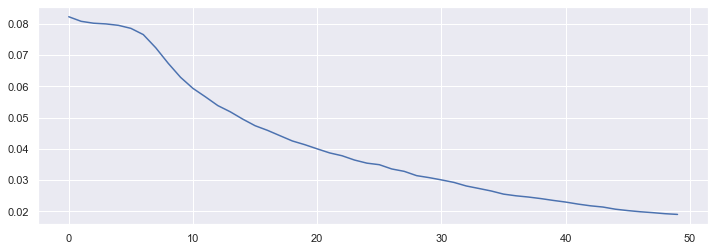

In [26]:
plt.plot(history.history['loss']);

The loss plot tells us that the networks output converges to the heuristic. That doesn't say anything about the quality yet. However, we're just interested in verifying the mechanics of the learning process and the neural network architecture. 

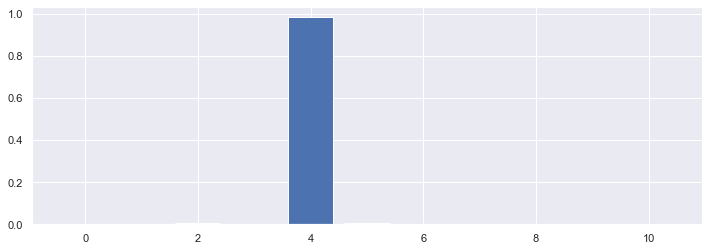

In [27]:
plt.bar(x = range(11), height=actor(batch[700:701]).numpy()[0]);

Our network says: Looking at the history of ten stocks at day 700, stock number 4 would be the winner. Well, let's see:

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

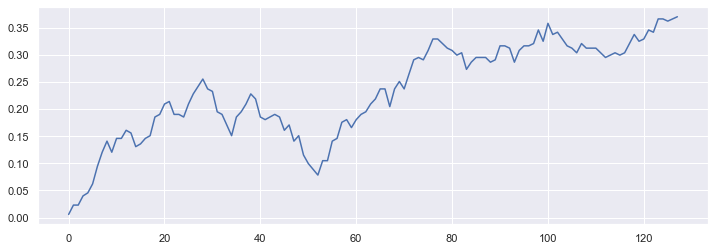

In [28]:
plt.plot(batch[700, :, 4, 0].cumsum());
winners[700]

Yup. That looks like a winner. I leave it up to you to verify that the other stocks perform weaker

## Conclusion

We have fed the market history into a neural network consisting of a single convolutional layer and three subsequent dense layers. The convolutional layers was equipped with 8 filters of length 128 that basically scan the entire history in a single go. The same set of filters is used for all the stocks. We trained with a heuristic to choose the best-performing stock in the current history and could easily verify that the network learns the given simple heuristic. Note that we didn't even afforded ourselves a separate validation test set, since at this point in time we're not interested in the ability to generalize. But exactly that's what comes in the next lab.